# Setup

This notebook copies and build out Part III of `jeff_classifier.py` - that is, the section that trains and tests a classifier on the generated data.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 150)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## First Classification

Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 148)


In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(etc_metrics.roc_auc.mean())
etc_metrics.loc[:, eval_columns]

0.861111111111111


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.250000,0.894737,0.980392,0.166667,0.823529,"[0.0, 0.0196078431373, 0.0196078431373, 0.1372...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.88251400489, 0.882514004893, 0.74, 0.22, 0...."
1,0.000000,0.824561,0.921569,0.000000,0.751634,"[0.0, 0.0588235294118, 0.0980392156863, 0.0980...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.89972804897, 0.899728048968, 0.49, 0.46, 0...."
2,0.000000,0.877193,0.980392,0.000000,0.630719,"[0.0, 0.0196078431373, 0.176470588235, 0.17647...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.88064484535, 0.880644845353, 0.17, 0.16, 0...."
3,0.166667,0.824561,0.901961,0.166667,0.905229,"[0.0, 0.078431372549, 0.0980392156863, 0.09803...","[0.0, 0.166666666667, 0.166666666667, 0.5, 0.6...","[1.89995248779, 0.899952487788, 0.609580854868..."
4,0.153846,0.807018,0.882353,0.166667,0.841503,"[0.0, 0.0980392156863, 0.117647058824, 0.11764...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.91580351996, 0.915803519962, 0.869241442639..."
5,0.285714,0.912281,1.000000,0.166667,0.949346,"[0.0, 0.0, 0.0392156862745, 0.0392156862745, 0...","[0.166666666667, 0.5, 0.5, 0.666666666667, 0.8...","[0.55, 0.42, 0.33, 0.27, 0.24, 0.23, 0.22, 0.1..."
6,0.444444,0.912281,0.980392,0.333333,0.818627,"[0.0, 0.0196078431373, 0.0196078431373, 0.1372...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.5...","[1.76491430986, 0.764914309858, 0.55, 0.34, 0...."
7,0.285714,0.912281,1.000000,0.166667,0.890523,"[0.0, 0.0, 0.078431372549, 0.117647058824, 0.1...","[0.166666666667, 0.333333333333, 0.33333333333...","[0.73, 0.39, 0.26, 0.22, 0.2, 0.19888384902, 0..."
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.1, 0.16, 0.24, 0.28, 0.3, 0.34, 0.38, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.761265091846, 0.27, 0.25, 0.18, 0.17, 0.14,..."
9,0.909091,0.981818,0.980000,1.000000,1.000000,"[0.0, 0.14, 0.22, 0.24, 0.28, 0.38, 0.42, 0.46...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.78637271457, 0.17, 0.15, 0.13, 0.12, 0.07, ..."


In [7]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_similar_images_count:max             0.042835
missing_exp_ads_from_simimages_count:max     0.033108
missing_similar_images_count:50%             0.031104
missing_exp_ads_from_simimages_count:50%     0.024144
missing_exp_ads_from_simimages_count:75%     0.022991
missing_exp_ads_from_simimages_count:mean    0.022114
missing_similar_images_count:mean            0.020084
missing_similar_images_count:std             0.018508
missing_exp_ads_from_simimages_count:std     0.017943
missing_similar_images_count:75%             0.017718
flag_Juvenile                                0.017661
n_incall                                     0.016182
n_ads                                        0.015910
age:min                                      0.014995
n_incall_and_outcall                         0.014335
images_count:min                             0.013553
n_distinct_locations                         0.013448
age:max                                      0.013415
images_count:max            

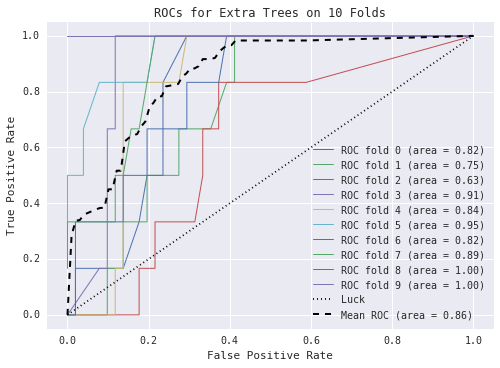

In [8]:
draw_rocs(etc_metrics, 'Extra Trees')

In [9]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(rf_metrics.roc_auc.mean())
rf_metrics.loc[:, eval_columns]

0.856045751633987


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.250000,0.894737,0.980392,0.166667,0.864379,"[0.0, 0.0196078431373, 0.0196078431373, 0.0784...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.88251400489, 0.882514004893, 0.6, 0.27, 0.2..."
1,0.000000,0.807018,0.901961,0.000000,0.733660,"[0.0, 0.0588235294118, 0.0980392156863, 0.0980...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.89972804897, 0.899728048968, 0.55, 0.43, 0...."
2,0.000000,0.877193,0.980392,0.000000,0.490196,"[0.0, 0.0196078431373, 0.078431372549, 0.11764...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166...","[1.88064484535, 0.880644845353, 0.22, 0.21, 0...."
3,0.285714,0.824561,0.882353,0.333333,0.895425,"[0.0, 0.078431372549, 0.117647058824, 0.117647...","[0.0, 0.166666666667, 0.166666666667, 1.0, 1.0...","[1.89995248779, 0.899952487788, 0.616684974303..."
4,0.000000,0.771930,0.862745,0.000000,0.839869,"[0.0, 0.0980392156863, 0.137254901961, 0.13725...","[0.0, 0.0, 0.0, 0.333333333333, 0.666666666667...","[1.91580351996, 0.915803519962, 0.66, 0.39, 0...."
5,0.500000,0.929825,1.000000,0.333333,0.952614,"[0.0, 0.0, 0.0392156862745, 0.0392156862745, 0...","[0.166666666667, 0.5, 0.5, 0.666666666667, 0.6...","[0.59, 0.37, 0.29, 0.28, 0.27, 0.26, 0.16, 0.1..."
6,0.444444,0.912281,0.980392,0.333333,0.831699,"[0.0, 0.0196078431373, 0.0196078431373, 0.0392...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.3...","[1.81218482, 0.81218482, 0.57, 0.44, 0.42, 0.2..."
7,0.666667,0.947368,1.000000,0.500000,0.952614,"[0.0, 0.0, 0.0196078431373, 0.0196078431373, 0...","[0.166666666667, 0.5, 0.5, 0.666666666667, 0.8...","[0.63, 0.52, 0.32, 0.28, 0.27, 0.18, 0.16, 0.1..."
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.04, 0.12, 0.2, 0.24, 0.26, 0.3, 0.36, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.761265091846, 0.42, 0.28, 0.19, 0.18, 0.16,..."
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.02, 0.06, 0.16, 0.22, 0.24, 0.3, 0.42,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.78637271457, 0.45, 0.39, 0.14, 0.12, 0.11, ..."


In [10]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_exp_ads_from_simimages_count:mean     0.035429
missing_similar_images_count:mean             0.033245
age:min                                       0.033187
age:count                                     0.030219
age:mean                                      0.028290
exp_ads_from_simimages_count:50%              0.025456
missing_age:count                             0.020479
age:max                                       0.020102
missing_similar_images_count:count            0.019596
missing_exp_ads_from_simimages_count:count    0.019392
flag_Juvenile                                 0.019364
n_ads                                         0.018821
missing_exp_ads_from_simimages_count:std      0.018572
missing_similar_images_count:std              0.018024
similar_images_count:25%                      0.017886
missing_price:count                           0.017616
missing_duration_in_mins:count                0.017075
similar_images_count:50%                      0.016949
missing_pr

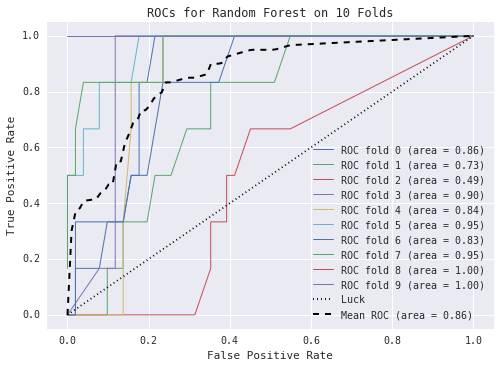

In [11]:
draw_rocs(rf_metrics, 'Random Forest')

## Second Classification
The same as above, but exclude price variables

In [12]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - price_cols - duration_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 100)


In [13]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(etc_metrics.roc_auc.mean())
etc_metrics.loc[:, eval_columns]

0.8647058823529413


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.250000,0.894737,0.980392,0.166667,0.797386,"[0.0, 0.0196078431373, 0.0196078431373, 0.1568...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.5...","[1.88251400489, 0.882514004893, 0.71, 0.17, 0...."
1,0.000000,0.824561,0.921569,0.000000,0.733660,"[0.0, 0.0588235294118, 0.0980392156863, 0.0980...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.89972804897, 0.899728048968, 0.46, 0.4, 0.3..."
2,0.000000,0.877193,0.980392,0.000000,0.638889,"[0.0, 0.0196078431373, 0.0980392156863, 0.1372...","[0.0, 0.0, 0.0, 0.0, 0.166666666667, 0.1666666...","[1.88064484535, 0.880644845353, 0.25, 0.22, 0...."
3,0.153846,0.807018,0.882353,0.166667,0.892157,"[0.0, 0.0196078431373, 0.0980392156863, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 1.0...","[1.90050057465, 0.900500574654, 0.899952487788..."
4,0.142857,0.789474,0.862745,0.166667,0.854575,"[0.0, 0.0980392156863, 0.137254901961, 0.13725...","[0.0, 0.0, 0.0, 0.833333333333, 0.833333333333...","[1.91580351996, 0.915803519962, 0.6, 0.25, 0.1..."
5,0.285714,0.912281,1.000000,0.166667,0.936275,"[0.0, 0.0196078431373, 0.0196078431373, 0.0588...","[0.166666666667, 0.166666666667, 0.5, 0.5, 0.8...","[0.77, 0.49, 0.39, 0.34, 0.29, 0.25, 0.19, 0.1..."
6,0.444444,0.912281,0.980392,0.333333,0.857843,"[0.0, 0.0196078431373, 0.0196078431373, 0.0784...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.5...","[1.7680080025, 0.768008002501, 0.64, 0.41, 0.3..."
7,0.285714,0.912281,1.000000,0.166667,0.936275,"[0.0, 0.0, 0.078431372549, 0.078431372549, 0.0...","[0.166666666667, 0.5, 0.5, 0.666666666667, 0.6...","[0.63, 0.34, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16..."
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.06, 0.1, 0.12, 0.16, 0.24, 0.28, 0.3, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.761265091846, 0.38, 0.32, 0.26, 0.25, 0.17,..."
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.18, 0.26, 0.3, 0.32, 0.44, 0.46, 0.5, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.78637271457, 0.16, 0.15, 0.14, 0.1, 0.07, 0..."


In [14]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_exp_ads_from_simimages_count:mean    0.036455
missing_exp_ads_from_simimages_count:max     0.031383
missing_similar_images_count:max             0.028768
missing_similar_images_count:50%             0.028527
missing_exp_ads_from_simimages_count:50%     0.027553
missing_similar_images_count:std             0.026427
missing_similar_images_count:mean            0.026383
missing_exp_ads_from_simimages_count:75%     0.024897
missing_exp_ads_from_simimages_count:std     0.022770
flag_Juvenile                                0.022339
missing_similar_images_count:75%             0.019417
missing_age:std                              0.018995
n_incall_and_outcall                         0.018927
n_incall                                     0.017645
images_count:min                             0.017269
images_count:75%                             0.015872
age:min                                      0.015597
n_cooccurring_phones                         0.015534
n_ads                       

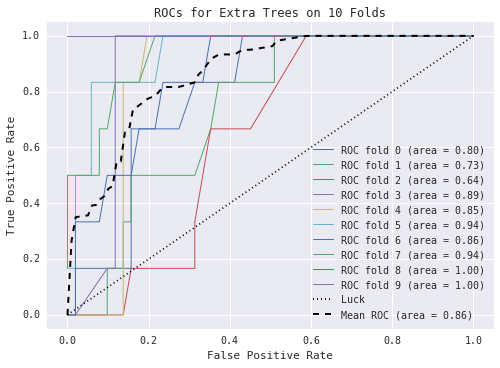

In [15]:
draw_rocs(etc_metrics, 'Extra Trees')

In [16]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(rf_metrics.roc_auc.mean())
rf_metrics.loc[:, eval_columns]

0.8712418300653596


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.250000,0.894737,0.980392,0.166667,0.885621,"[0.0, 0.0196078431373, 0.0196078431373, 0.0784...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.88251400489, 0.882514004893, 0.61, 0.32, 0...."
1,0.000000,0.807018,0.901961,0.000000,0.751634,"[0.0, 0.0588235294118, 0.0980392156863, 0.0980...","[0.0, 0.0, 0.0, 0.333333333333, 0.333333333333...","[1.89972804897, 0.899728048968, 0.58, 0.36, 0...."
2,0.000000,0.877193,0.980392,0.000000,0.581699,"[0.0, 0.0196078431373, 0.078431372549, 0.11764...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666...","[1.88064484535, 0.880644845353, 0.266857218412..."
3,0.400000,0.842105,0.882353,0.500000,0.893791,"[0.0, 0.0980392156863, 0.117647058824, 0.11764...","[0.0, 0.166666666667, 0.166666666667, 1.0, 1.0...","[1.89995248779, 0.899952487788, 0.881979619202..."
4,0.000000,0.771930,0.862745,0.000000,0.852941,"[0.0, 0.0980392156863, 0.137254901961, 0.13725...","[0.0, 0.0, 0.0, 0.833333333333, 0.833333333333...","[1.91580351996, 0.915803519962, 0.7, 0.13, 0.0..."
5,0.500000,0.929825,1.000000,0.333333,0.952614,"[0.0, 0.0, 0.078431372549, 0.078431372549, 0.0...","[0.166666666667, 0.5, 0.5, 0.666666666667, 0.6...","[0.54, 0.45, 0.28, 0.27, 0.26, 0.23, 0.18, 0.1..."
6,0.444444,0.912281,0.980392,0.333333,0.857843,"[0.0, 0.0196078431373, 0.0196078431373, 0.0588...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.3...","[1.82406890934, 0.824068909339, 0.68, 0.42, 0...."
7,0.285714,0.912281,1.000000,0.166667,0.936275,"[0.0, 0.0, 0.0196078431373, 0.0196078431373, 0...","[0.166666666667, 0.333333333333, 0.33333333333...","[0.51, 0.48, 0.44, 0.38, 0.32, 0.25, 0.22, 0.1..."
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.12, 0.18, 0.2, 0.28, 0.3, 0.34, 0.44, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.761265091846, 0.3, 0.24, 0.18, 0.14, 0.1, 0..."
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 0.04, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.78637271457, 0.38, 0.16, 0.14, 0.11, 0.1, 0..."


In [17]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_exp_ads_from_simimages_count:mean     0.048397
missing_similar_images_count:mean             0.046173
age:min                                       0.040083
age:count                                     0.034107
age:mean                                      0.029805
n_ads                                         0.024539
missing_similar_images_count:count            0.023984
flag_Juvenile                                 0.022391
missing_age:count                             0.021887
missing_exp_ads_from_simimages_count:count    0.021461
age:std                                       0.021283
similar_images_count:25%                      0.019891
missing_exp_ads_from_simimages_count:std      0.019112
missing_similar_images_count:std              0.018925
similar_images_count:75%                      0.018118
images_count:25%                              0.018116
images_count:mean                             0.017846
age:max                                       0.017666
images_cou

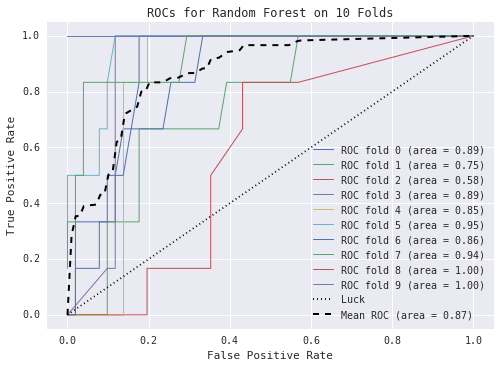

In [18]:
draw_rocs(rf_metrics, 'Random Forest')

## Third Classification

Here, we *just* use pricing and time data.

In [19]:
y_series = df['class']
X_df = df.loc[:, sorted(price_cols | duration_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 48)


In [20]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(etc_metrics.roc_auc.mean())
etc_metrics.loc[:, eval_columns]

0.5427843137254902


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.444444,0.912281,0.980392,0.333333,0.647059,"[0.0, 0.0196078431373, 0.0196078431373, 0.1372...","[0.166666666667, 0.166666666667, 0.33333333333...","[0.76, 0.758764818705, 0.69, 0.44482441206, 0...."
1,0.181818,0.842105,0.921569,0.166667,0.537582,"[0.0, 0.0196078431373, 0.0588235294118, 0.0588...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.72, 0.72, 0.64, 0.61, 0.563218137145, 0.472..."
2,0.000000,0.894737,1.000000,0.000000,0.393791,"[0.0, 0.352941176471, 0.372549019608, 0.411764...","[0.0, 0.166666666667, 0.166666666667, 0.166666...","[1.47009335967, 0.470093359668, 0.448130932429..."
3,0.113208,0.175439,0.137255,0.500000,0.490196,"[0.0, 0.0, 0.862745098039, 0.862745098039, 0.8...","[0.166666666667, 0.333333333333, 0.5, 0.666666...","[0.73, 0.583029449243, 0.531678933798, 0.37, 0..."
4,0.043478,0.228070,0.235294,0.166667,0.282680,"[0.0, 0.764705882353, 0.78431372549, 0.8235294...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.79, 0.537204242227, 0.417746532509, 0.28639..."
5,0.266667,0.807018,0.862745,0.333333,0.735294,"[0.0, 0.0196078431373, 0.0588235294118, 0.1372...","[0.166666666667, 0.333333333333, 0.33333333333...","[0.83, 0.69697551082, 0.69, 0.525351631642, 0...."
6,0.166667,0.824561,0.901961,0.166667,0.473856,"[0.0, 0.0196078431373, 0.0588235294118, 0.0588...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.71653092511, 0.716530925113, 0.668597961582..."
7,0.166667,0.824561,0.901961,0.166667,0.547386,"[0.0, 0.0196078431373, 0.0196078431373, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.89244434933, 0.892444349325, 0.8, 0.4802340..."
8,0.000000,0.767857,0.860000,0.000000,0.650000,"[0.0, 0.02, 0.1, 0.14, 0.26, 0.44, 0.48, 0.62,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.87032891551, 0.870328915505, 0.58, 0.543599..."
9,0.000000,0.745455,0.820000,0.000000,0.670000,"[0.0, 0.02, 0.06, 0.16, 0.18, 0.22, 0.24, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.66, 0.66, 0.535894457639, 0.529276037409, 0..."


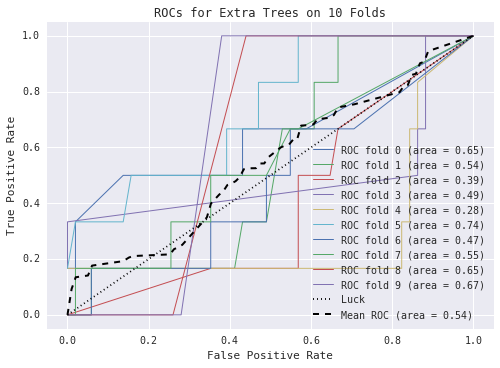

In [21]:
draw_rocs(etc_metrics, 'Extra Trees')

In [22]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(rf_metrics.roc_auc.mean())
rf_metrics.loc[:, eval_columns]

0.5254640522875816


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.400000,0.894737,0.960784,0.333333,0.643791,"[0.0, 0.0196078431373, 0.0196078431373, 0.0392...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.5...","[1.71484714255, 0.714847142549, 0.65, 0.55, 0...."
1,0.181818,0.842105,0.921569,0.166667,0.568627,"[0.0, 0.0196078431373, 0.0392156862745, 0.0784...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.7, 0.7, 0.66, 0.563218137145, 0.47232480965..."
2,0.000000,0.877193,0.980392,0.000000,0.362745,"[0.0, 0.0196078431373, 0.372549019608, 0.41176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.56027017891, 0.560270178911, 0.470093359668..."
3,0.113208,0.175439,0.137255,0.500000,0.490196,"[0.0, 0.0, 0.862745098039, 0.862745098039, 0.8...","[0.166666666667, 0.333333333333, 0.5, 0.666666...","[0.738960784314, 0.606682738671, 0.53167893379..."
4,0.043478,0.228070,0.235294,0.166667,0.264706,"[0.0, 0.764705882353, 0.78431372549, 0.8235294...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.66, 0.537204242227, 0.417746532509, 0.28639..."
5,0.315789,0.771930,0.803922,0.500000,0.696078,"[0.0, 0.0392156862745, 0.0588235294118, 0.0980...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.86, 0.86, 0.714053524263, 0.603183841949, 0..."
6,0.000000,0.771930,0.862745,0.000000,0.359477,"[0.0, 0.0196078431373, 0.0392156862745, 0.0784...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.79961019302, 0.799610193024, 0.717499720843..."
7,0.307692,0.842105,0.901961,0.333333,0.549020,"[0.0, 0.0196078431373, 0.0588235294118, 0.0588...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.88016471016, 0.88016471016, 0.71, 0.7, 0.65..."
8,0.000000,0.732143,0.820000,0.000000,0.650000,"[0.0, 0.02, 0.12, 0.16, 0.26, 0.44, 0.48, 0.52...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.89, 0.89, 0.590910761692, 0.543599750307, 0..."
9,0.000000,0.745455,0.820000,0.000000,0.670000,"[0.0, 0.04, 0.06, 0.16, 0.18, 0.22, 0.24, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.64, 0.64, 0.530037680145, 0.529276037409, 0..."


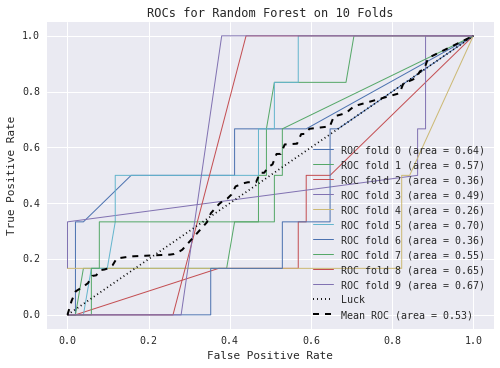

In [23]:
draw_rocs(rf_metrics, 'Random Forest')